<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/notebooks/LSTM_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please create a copy of the notebook to play around and leave the original copy untouched for other students and intructors!

# Import all libraries we will need

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Connect to Goole Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [ ]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [ ]:
# Let's filter the data for one store and one item to keep it simple
store_ids = [1]
item_ids = [96995]
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-4-bd7586eec8b9>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


# Prepare data

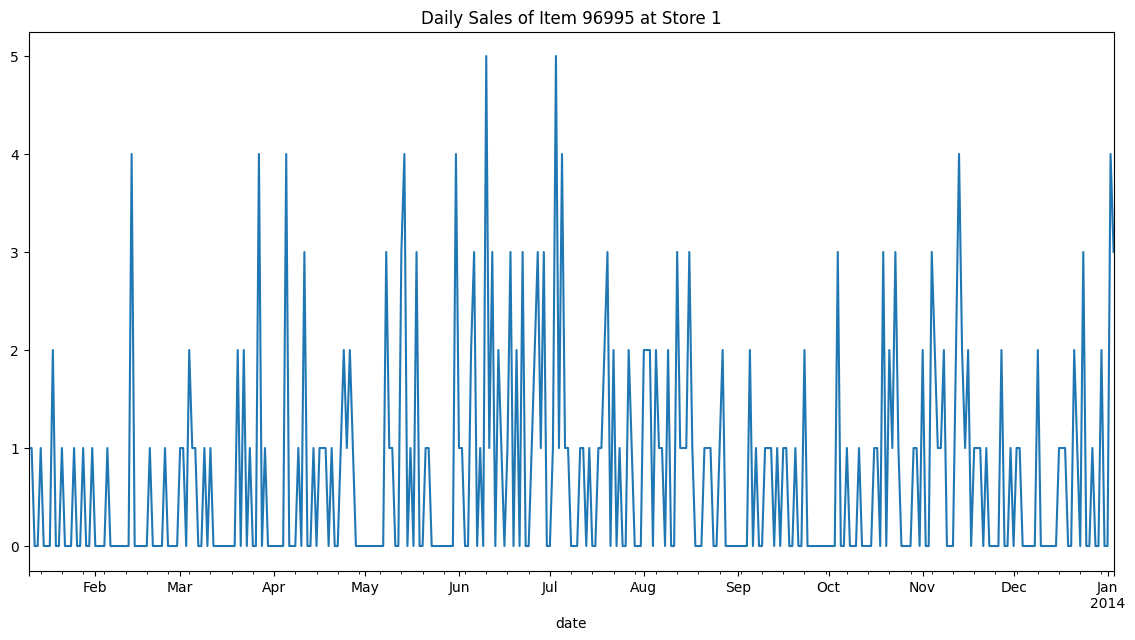

In [ ]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and aggregate sales
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered['unit_sales'].plot()
plt.title('Daily Sales of Item 96995 at Store 1')
plt.show()

# Preprocessing the Data for LSTM

In [ ]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_filtered['unit_sales'] = scaler.fit_transform(df_filtered[['unit_sales']])

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Create sequences
data = df_filtered['unit_sales'].values
X, y = create_sequences(data, seq_length)

# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# LSTM model

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0684 - val_loss: 0.0603
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0587 - val_loss: 0.0514
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0482 - val_loss: 0.0441
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0478 - val_loss: 0.0449
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0437 - val_loss: 0.0437
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0449 - val_loss: 0.0440
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0558 - val_loss: 0.0448
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0448 - val_loss: 0.0453
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0432 - val_loss: 0.0447
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0477 - val_loss: 0.0439
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0415 - val_loss: 0.0436
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0484 - val_loss: 0.0436


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


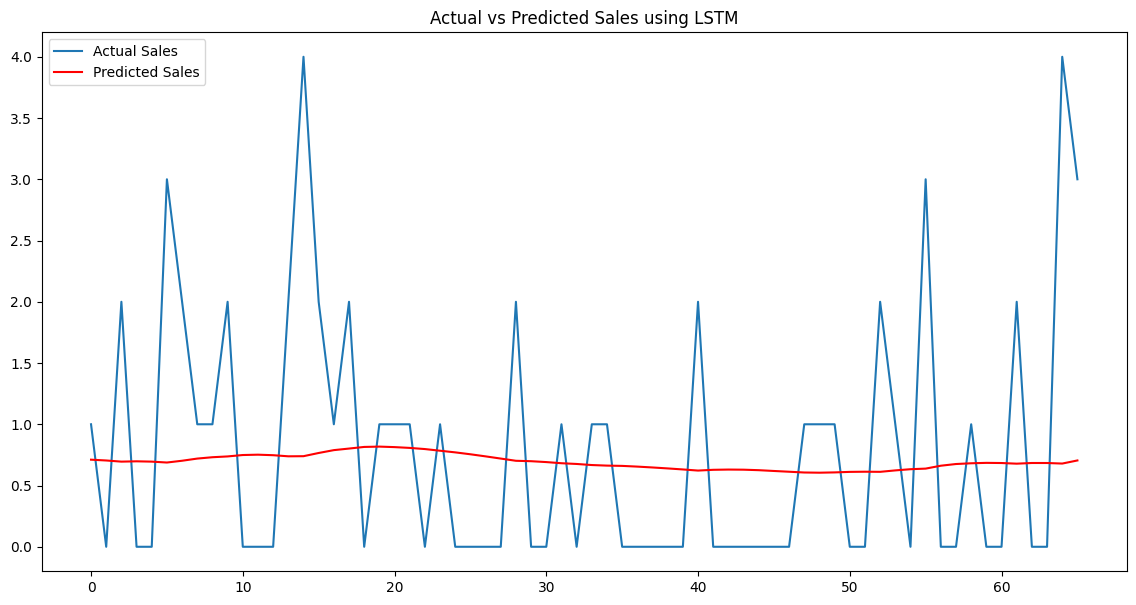

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()
